# Imports

In [1]:
import os
import json
import datetime
from pathlib import Path
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Code

In [2]:
class BaseRun:
    def __init__(self, path):
        self.path = path
    
    def init_file(self, name):
        params = list(self.path.rglob(name))
        assert len(params) == 1, params
        return params[0].absolute()
    
    def __len__(self):
        return len(self.data)
        

In [113]:
class CrRun(BaseRun):
    def __init__(self, path):
        super(CrRun, self).__init__(path)
        self.conf_file = self.init_file('params.json')
        self.log_file = self.init_file('log.txt')
        self.name = os.path.basename(path)
        
        with open(self.conf_file, 'r') as f:
            d = json.load(f)
            self.params = OrderedDict(sorted(d.items(), key=lambda x:x[0], reverse=False))
        with open(self.log_file, 'r') as f:
            self.logs = f.read()
            
        self.data = self.read_logs()
        
    def parse_name(self, prefix='run_'):
        date = self.name.strip(prefix)#.rstrip('.lock')
        start_time = datetime.datetime.strptime(date, '%Y_%b_%d_%H_%M_%S_%f')
        return start_time
        
    def best(self, val=False, num=1, ascending=False):
        pos = 'val_acc' if val else 'acc'
        return self.data.sort_values(pos, ascending=ascending)[:num]
    
    def total_time(self):
        return self.data['duration'][self.__len__()-1]
    
    def start_time(self):
        return self.data['date'][0]
    
    def read_logs(self):
        data = []
        num_data = []
        for l in self.logs.split('\n'):
            if l:
                d,g,v,va = l.split(',')
                g, v, va = int(g), float(v), float(va)
                data.append([d,g,v,va])
                num_data.append([g,v,va])
        
        df = pd.DataFrame(data, columns=['date','epoch','acc','val_acc'])
        df['val_acc'].replace(-1., np.NaN, inplace=True)
        df.fillna(method='ffill', inplace=True)
        df.set_index('epoch', inplace=True)
        
        timeDF=(pd.to_datetime(df['date'].str.strip(), format='%H:%M:%S'))
        df['date'] = timeDF
        df['duration'] = timeDF - timeDF[0]
        
        return df
    
    
    def plot(self, cols=None, window=1,limits=[-1,-1], ax=None, x=None):
        if ax is None:
            f,ax = plt.subplots(1)
        if cols is None:
            cols = ['Acc']
        if x is not None:
            cols.append(x)
        
        llim, rlim = limits
        rlim = len(self.data) if rlim <=0 else rlim
        llim = max(0, llim)
        
        
        d = self.data.iloc[llim:rlim,:]
        d = d.loc[:,cols]
        for c in cols:
            if c != 'duration':
                d[c] = d[c].rolling(window).mean() 
        
        d.plot(figsize=(12,7), ax=ax, x=x)

In [198]:
def load_anal(runs):
    dd = {}
    for run in runs.values():
        run_best = run.best(num=3, val=True)
        #run_best_pct = 100 - int( 100 * (run.total_time() - dur) / run.total_time())
        d = {}
        d['name'] = run.name
        d['tt'] = run.total_time()
        d['t2b'] = run_best['duration'].values[0]
        d['ba'] = round(run_best.mean()[['acc']].values[0],3)
        d['bva'] = round(run_best.mean()[['val_acc']].values[0],3)
        d['la'] = round(run.data['acc'][-10:].mean(),3)
        d.update(**run.params)
        dd[run.parse_name()] = d
    #res_df = pd.DataFrame(results, columns=['Name','duration', 'LRM', 'best_acc', 'best_val', 'best_pct', *run.params.keys()])
    
    df = pd.DataFrame(dd).T
    return df

In [199]:
def is_valid(path):
    return True

def run_inits(run_path):
    registry = OrderedDict()
    for r in run_path:
        if is_valid(r):
            try:
                run = CrRun(r)
                registry[run.name] = run
            except Exception as e:
                #print(e)
                pass
                #print(f'Err {r}')
    print(f'Valid: {len(registry.keys())}; total:{len(run_path)}')
    return registry

In [200]:
def mod_df(df, col='acc', window=1, div=1):
    d = df.loc[:, [col, 'duration']]
    s = d['duration'].apply(lambda x: x.seconds)/div
    d.loc[:,'duration'] = s
    
    s = d[col].rolling(window).mean()
    d.loc[:,col] = s
    return d

def plot_run(run, col, ax,  window=5):
    d = mod_df(run.data, col=col, window=window)
    d.plot('duration', ax=ax)

# Tests

In [201]:
p = Path('./cycler_runs')
run_paths = list(p.iterdir())

In [202]:
rs = run_inits(run_paths)
df = load_anal(rs)

Valid: 79; total:100


In [203]:
df = df.sort_values('bva', ascending=False)
#df = df.sort_values('Name', ascending=False)
#df.head(5)

In [204]:
cols = set(df.columns.values) - set(['name', 'tt', 't2b'])

In [205]:
cols = ['combine_chance', 'mutate_chance', 'exp_power', 'crossover_chance', 'la', 'bva']

In [206]:
dt = datetime.timedelta(minutes=5)
tdf = df[df['tt'] > dt]
tdf = tdf[cols].astype(float)
t = tdf.corr()
t

,combine_chance,mutate_chance,exp_power,crossover_chance,la,bva
combine_chance,1.000000,0.049835,-0.112429,0.055819,0.062229,0.027227
mutate_chance,0.049835,1.000000,-0.038499,0.062938,0.128362,0.168161
exp_power,-0.112429,-0.038499,1.000000,0.002847,0.155866,0.205165
crossover_chance,0.055819,0.062938,0.002847,1.000000,0.629392,0.698262
la,0.062229,0.128362,0.155866,0.629392,1.000000,0.902583
bva,0.027227,0.168161,0.205165,0.698262,0.902583,1.000000


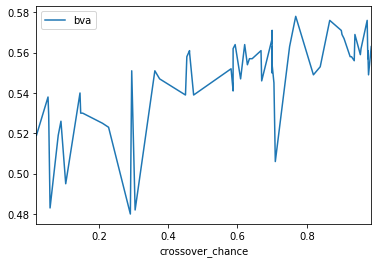

In [207]:
tdf.sort_values('crossover_chance').plot( 'crossover_chance','bva')

In [208]:
df

,name,tt,t2b,ba,bva,la,combine_chance,crossover_chance,dec_f0,dec_f1,dec_f2,dec_f3,exp_power,generation_size,generations,mutate_chance,seed,subsample_size
2020-05-11 00:14:35.375333,run_2020_May_11_00_14_35_375333,00:06:58,00:05:27,0.569,0.578,0.554,0.54026,0.768076,12,10,8,6,10,200,200,0.00420641,0,50
2020-05-11 00:50:47.635807,run_2020_May_11_00_50_47_635807,00:07:06,00:07:06,0.607,0.576,0.587,0.475451,0.974289,12,10,8,6,5,200,200,0.00401703,0,50
2020-05-11 01:26:47.870634,run_2020_May_11_01_26_47_870634,00:07:00,00:07:00,0.585,0.576,0.576,0.583467,0.866273,12,10,8,6,5,200,200,0.00206012,0,50
2020-05-13 20:34:25.380772,run_2020_May_13_20_34_25_380772,00:07:24,00:06:31,0.563,0.571,0.587,0.5,0.7,12,10,8,6,5,200,200,0.003,0,50
2020-05-11 00:21:47.798885,run_2020_May_11_00_21_47_798885,00:06:57,00:05:53,0.549,0.571,0.578,0.367435,0.899659,12,10,8,6,5,200,200,0.00186172,0,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-13 18:32:51.938747,run_2020_May_13_18_32_51_938747,00:00:09,00:00:00,0.086,0.063,0.092,0.913407,0.893768,12,10,8,6,10,200,5,0.00400802,0,50
2020-05-13 18:44:54.627127,run_2020_May_13_18_44_54_627127,00:00:09,00:00:00,0.072,0.062,0.073,0.81521,0.807355,12,10,8,6,1,200,5,0.000653307,0,50
2020-05-13 18:45:24.775846,run_2020_May_13_18_45_24_775846,00:00:09,00:00:00,0.076,0.059,0.077,0.149439,0.872164,12,10,8,6,10,200,5,0.00489178,0,50
2020-05-13 18:45:24.817203,run_2020_May_13_18_45_24_817203,00:00:00,00:00:00,0.064,0.058,0.064,0.157295,0.279058,12,10,8,6,50,200,5,0.00227655,0,50


In [73]:
plot_df = df[:1]
top = df.sort_values(by='la', ascending=False)[:5]
plot_df = pd.concat([plot_df,top])

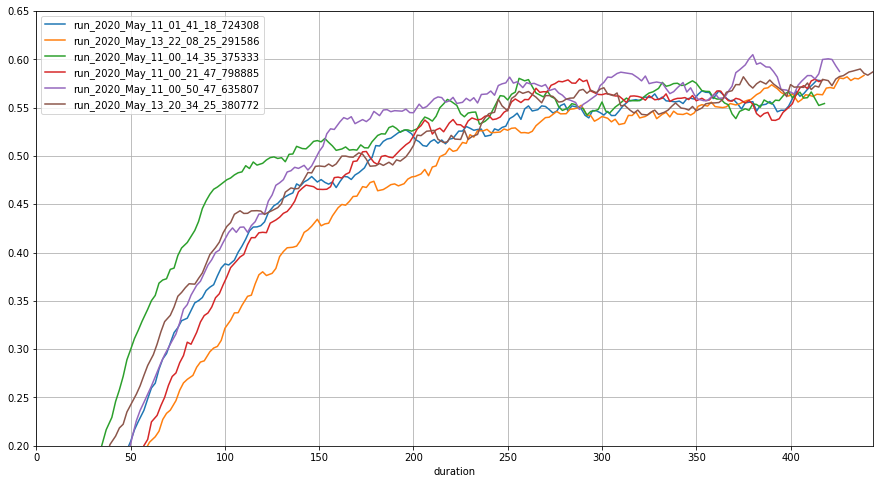

In [210]:
f, a = plt.subplots(1, figsize=(15,8))
#l_lim, r_lim = 0, 1000

rsp = [r for r in rs.values() if r.name in plot_df.name.values]

[plot_run(r, col='acc', ax=a, window=10) for r in rsp]

a.legend([r.name for r in rsp])
#axs.legend(['Validation', 'Train'])

#a.set_xticks(np.arange(l_lim, 700, 10))
#a.set_yticks(np.arange(0.1, .9, 0.05))
plt.ylim(.2,.65)
plt.grid()